# HKA Test and Homogeneity Test AOcol vs GAgam

## Homogeneity Test 

Under neutral evolution, we expect the amount of within- and between-species diversity to be correlated. If, however, selection events occur on the branch of a gene, we expect a reduction of polymorphic sites in one species only, compared to the levels of genetic variation and divergence in the other:

* A = number of polymorphic sites in the <i>An.coluzzii</i> samples;
* B = number of polymorphic sites in the <i>An.gambiae</i> samples;

* C = number of fixed differences between <i>An.coluzzii</i> and <i>An.gambiae</i> and <i>An.christyi</i> sequence;
* D = number of fixed differences between <i>An.gambiae</i> and <i>An.coluzzii</i>. and <i>An.christyi</i> sequence;

It was performed a homogeneity test for the null hypothesis A/C = B/D equivalent to A/B =C/D. Then was used a Pearson's chi-square test on the 2x2 contingency table. Because of LD, the resulting ‘P-values’ are not accurate and do not have the interpretation expected under the multinomial model underlying the assumption of the Pearson’s chi-square test. The issue resembles the well-known issues relating to HKA tests in population genetics, in which simulations under specific demographic models are needed to assign P-values. In the polar bear paper, they didn't attempt to present valid P-values based on demographic simulations, due to concerns regarding underlying parameters such as recombination rates.

Instead, they only provide ranked lists of genes and rely on enrichment analyses, and arguments regarding lack of symmetry between polar and brown bears, to provide statistical evidence for an effect reflecting what could be expected by chance in the absence of selection. To avoid misunderstandings regarding the interpretation of the ‘P-value’, they convert them to a score using -log10(P-value). They reported this score rather than the ‘P-value’ itself to avoid misunderstandings of the interpretation of this statistic

## HKA Test
The HKA test is based on the neutral theory of molecular evolution (Kimura 1983) which predicts that for a particular region of the genome, its rate of evolution is correlated with the levels of polymorphism within species. The test requires data from at least two regions of the genome both for an interspecific comparison and also data for the intraspecific polymorphism from at least one species.

Polymorphism levels depend on local mutation rates, measured from divergence values using an outgroup species. The HKA test is commonly used to verify this expectation and tests whether the decrease of polymorphism observed at a locus is due to positive selection and genetic hitchhiking.

The HKA test was performed comparing the ratio of A/C for each gene to the genome-wide average, computed as the sum of A and C values across all genes analyzed for <i>An.coluzzii</i> and the same on the ratio B/D for <i>An.gambiae</i> .


## Import modules and path for test

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import petl as etl
import anhima
import zarr
import allel
import itertools
import random
import seaborn as sns
import petlx.bio
import csv
import scipy
import intervaltree
from IPython.display import Image

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
call = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic')
out_alleles = h5py.File('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.h5')
ac_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/phase2_biallel_allele_count.zarr/')
out_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.zarr/')
annotation = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic_snpeff/')
samples = list(call['3L/samples'])
contigs = ['3L', '3R', '2R', '2L', 'X']
samples = [str(s) for s in call["3L"]["samples"][:]]
tbl_samples = etl.fromcsv('/mnt/70D89269D8922CFA/Genomes/meta/samples.meta.txt', delimiter='\t')

## Ag1000G Step
Take the 2 populations for the test, subsect the metadata

In [9]:
m = tbl_samples.select(lambda r: r.m_s == 'M' and r.population == 'AOcol').values('ox_code').list()
s = tbl_samples.select(lambda r: r.m_s == 'S' and r.population == 'GAgam').values('ox_code').list()
index_m = [samples.index(i) for i in m]
index_s = [samples.index(i) for i in s]

In [10]:
print('coluzzii samples:', len(index_m), '\n', 'gambiae samples:', len(index_s))

coluzzii samples: 78 
 gambiae samples: 69


Take from the annotation callset all the variants expect the intergenic variants, upstream gene variants and downstream gene variants positions for each chromosome

In [11]:
ann = {chrom: annotation[chrom]['variants/ANN_Annotation'][:] for chrom in contigs}

In [12]:
sel = {chrom: ((ann[chrom] != b'intergenic_variant') & (ann[chrom] != b'upstream_gene_variant') &
(ann[chrom] != b'downstream_gene_variant')) for chrom in contigs}

In [13]:
del ann
#It will reduce the ammount of RAM used

Loading the genotype array for each chromosome:

In [14]:
ga = {chrom: allel.GenotypeChunkedArray(call[chrom]['calldata/GT']) for chrom in contigs}

In [15]:
is_bial_genes = {chrom: sel[chrom] for chrom in contigs}

In [17]:
ga = {chrom: ga[chrom].compress(is_bial_genes[chrom], axis=0) for chrom in contigs}

Subset genotypes with my annotation selection

Creating 2 different genotypes arrays for each population:

In [18]:
# coluzzii
random_index = random.sample(index_m, 69)
gm = {chrom: ga[chrom].take(index_m, axis=1) for chrom in contigs}

In [19]:
# gambiae. Because population is bigger than coluzzii I take randomly the same number of samples
gs = {chrom: ga[chrom].take(index_s, axis=1) for chrom in contigs}

Performing the allele counts for each population and find their segregating sites:

In [20]:
acm = {chrom: gm[chrom].count_alleles() for chrom in contigs}
seg_m = {chrom: acm[chrom].count_segregating() for chrom in contigs}
is_seg_m = {chrom: acm[chrom].is_segregating() for chrom in contigs}

In [21]:
acs = {chrom: gs[chrom].count_alleles() for chrom in contigs}
seg_s = {chrom: acs[chrom].count_segregating() for chrom in contigs}
is_seg_s = {chrom: acs[chrom].is_segregating() for chrom in contigs}

In [22]:
for chrom in contigs:
    print('seg sites coluzii chrom %s:' % chrom, seg_m[chrom])

seg sites coluzii chrom 3L: 905470
seg sites coluzii chrom 3R: 1209686
seg sites coluzii chrom 2R: 1266270
seg sites coluzii chrom 2L: 966385
seg sites coluzii chrom X: 355795


In [23]:
for chrom in contigs:
    print('seg sites gambiae chrom %s:' % chrom, seg_s[chrom])

seg sites gambiae chrom 3L: 1146616
seg sites gambiae chrom 3R: 1635111
seg sites gambiae chrom 2R: 1752127
seg sites gambiae chrom 2L: 1195164
seg sites gambiae chrom X: 369285


Performing the allele frequency for each population:

In [24]:
#allele frequency
af_gambiae = {chrom: acs[chrom].to_frequencies() for chrom in contigs}

In [25]:
#allele frequency
af_coluzzii = {chrom: acm[chrom].to_frequencies() for chrom in contigs}

Take from my segregating sites only those alleles that are in my annotation selection:

In [26]:
pos = {chrom: call[chrom]['variants/POS'][:] for chrom in contigs}
pos_bial_genes = {chrom: np.compress(is_bial_genes[chrom], pos[chrom]) for chrom in contigs}

In [27]:
segreg_c = {chrom: np.compress(is_seg_m[chrom], pos_bial_genes[chrom]) for chrom in contigs}
segreg_g = {chrom: np.compress(is_seg_s[chrom], pos_bial_genes[chrom]) for chrom in contigs}

-----------------------------

## Outgroup step
In this section with the outgroup polariztion I take only the variants that are present in my outgroup to find private fixed alleles for my 2 populations:

In [28]:
outgroups = ['chri']

In [29]:
# af biallelic in genes
af_out = {}
for out in outgroups:
    af_out[out] = {}
    for chrom in contigs:
        allele_count = out_count[chrom][out][:]
        allele_count_bial_genes = np.compress(is_bial_genes[chrom], allele_count, axis=0)
        allele_number = allele_count_bial_genes.sum(axis=1)[:, np.newaxis]
        af_out[out][chrom] = np.where(allele_number > 0, allele_count_bial_genes / allele_number, 0)

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [30]:
#filter bial in genes
out_al = {}
for chrom in contigs:
    out_al[chrom] = {}
    for out in outgroups:
        out_al[chrom][out] = out_alleles[chrom][out][:]
        out_al[chrom][out] = np.compress(is_bial_genes[chrom], out_al[chrom][out])

In [31]:
assert out_al[chrom][out].shape[0] == af_out[out][chrom].shape[0]

In [32]:
def consensus_aa(chrom, out_alleles, outgroups):
    aa = None
    for out in outgroups:
        if aa is None:
            aa = out_alleles[chrom][out]
        else:
            loc_consensus = aa == out_alleles[chrom][out]
            aa[~loc_consensus] = b'.'
    return aa

In [33]:
aa = {chrom: consensus_aa(chrom, out_al, ['chri']) for chrom in contigs}

In [34]:
# load ag1000g alleles
ref = {chrom: call[chrom]['variants/REF'][:] for chrom in contigs}
alt = {chrom: call[chrom]['variants/ALT'][:] for chrom in contigs}

In [35]:
# filter for bial in genes
ref_bial_genes = {chrom: np.compress(is_bial_genes[chrom], ref[chrom]) for chrom in contigs}
alt_bial_genes = {chrom: np.compress(is_bial_genes[chrom], alt[chrom]) for chrom in contigs}

In [36]:
bool_aa_match = {chrom: (aa[chrom] != b'.') & ((aa[chrom] == ref_bial_genes[chrom]) | (aa[chrom] == alt_bial_genes[chrom])) for chrom in contigs}

In [37]:
for chrom in contigs:
    ref[chrom] = ref_bial_genes[chrom].compress(bool_aa_match[chrom], axis=0)
    alt[chrom] = alt_bial_genes[chrom].compress(bool_aa_match[chrom], axis=0)
    af_coluzzii[chrom] =  af_coluzzii[chrom].compress(bool_aa_match[chrom], axis=0)
    af_gambiae[chrom] = af_gambiae[chrom].compress(bool_aa_match[chrom], axis=0)
    aa[chrom] = aa[chrom].compress(bool_aa_match[chrom], axis=0)
    pos_bial_genes[chrom] = pos_bial_genes[chrom].compress(bool_aa_match[chrom], axis=0)
    out = 'chri'
    af_out[out][chrom] = af_out[out][chrom].compress(bool_aa_match[chrom], axis=0)

In [38]:
bool_no_fixed = {chrom:(((af_out['chri'][chrom][:,1]  != 0) & (af_out['chri'][chrom][:,1] != 1)) 
                        ) for chrom in contigs}

In [39]:
af_gambiae_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_gambiae[chrom], axis=0) for chrom in contigs}
af_coluzzii_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_coluzzii[chrom], axis=0) for chrom in contigs}
af_novar_out = {}
for out in ['chri']:
        af_novar_out[out] = {chrom: np.compress(~bool_no_fixed[chrom], af_out[out][chrom], axis=0) for chrom in contigs}     

In [40]:
pos_bial_genes = {chrom: np.compress(~bool_no_fixed[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [41]:
def find_private_fixed_derived_gambiae(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_coluzzii[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                                   
                        

In [42]:
def find_private_fixed_derived_coluzzii(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_gambiae[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                 

In [43]:
fixed_g = find_private_fixed_derived_gambiae(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_g['3L']

array([ 5528640, 10952921, 11989794, 16556513, 17163911, 25060879,
       34883729, 34883742, 34884498, 34889603, 35726249, 35726457,
       35726718, 35726743, 35813922, 35814861, 35814873, 35815019,
       41365173, 41775147], dtype=int32)

In [44]:
fixed_c = find_private_fixed_derived_coluzzii(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_c['3L']

array([ 5527611,  9663155, 11990120, 14481156, 16557333, 16564670,
       16690981, 17600983, 25063740, 25070089, 25154529, 25154874,
       29253861, 29253926, 29267523, 35721577, 35726424, 35726750,
       35726960, 35813220, 35813317, 35813913, 37162424, 39682874, 39801601], dtype=int32)

----------------------------

## Perform the statistic

In this part of the notebook I load the PEST gene annotation and i create 2 tables where there are the genes respect my fixed/segregating allels for my two populations and i run the chi-square test:

In [45]:
def count_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == '%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["ID"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    aggregate = interval_join.aggregate('genes', len).rename('value', species)
    return aggregate

In [46]:
#A
count_segreg_coluzzii = {chrom: count_variants_per_gene(chrom, segreg_c, 'coluzzii_segreg') for chrom in contigs}

In [47]:
#B
count_segreg_gambiae = {chrom: count_variants_per_gene(chrom, segreg_g, 'gambiae_segreg') for chrom in contigs}

In [48]:
#C
count_fixed_coluzzii = {chrom: count_variants_per_gene(chrom, fixed_c, 'coluzzii_fixed') for chrom in contigs}

In [49]:
#D
count_fixed_gambiae = {chrom: count_variants_per_gene(chrom, fixed_g, 'gambiae_fixed') for chrom in contigs}

In [50]:
# join (A and C) - (B and D)
joi_seg_fix_coluzzii = {chrom: count_fixed_coluzzii[chrom].join(count_segreg_coluzzii[chrom], key='genes') for chrom in contigs}
joi_seg_fix_gambiae  = {chrom: count_fixed_gambiae[chrom].join(count_segreg_gambiae[chrom], key='genes') for chrom in contigs}

In [51]:
# calculate the ratio for each gene
joi_seg_fix_coluzzii= {chrom: joi_seg_fix_coluzzii[chrom].addfield('A/C (i.e.seg/fix)', lambda r: r.coluzzii_segreg / r.coluzzii_fixed)
                       for chrom in contigs}
joi_seg_fix_gambiae= {chrom: joi_seg_fix_gambiae[chrom].addfield('B/D (i.e.seg/fix)', lambda r: r.gambiae_segreg / r.gambiae_fixed)
                       for chrom in contigs}
joi_seg_fix_coluzzii['2R'].display()
joi_seg_fix_gambiae['2R'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix)
AGAP001410,2,414,207.0
AGAP001412,1,536,536.0
AGAP001609,1,592,592.0
AGAP001658,3,225,75.0
AGAP001660,2,896,448.0


genes,gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP001125,1,37,37.0
AGAP001271,2,364,182.0
AGAP001410,2,661,330.5
AGAP001638,2,122,61.0
AGAP001658,1,405,405.0


In [52]:
joi_gambiae_coluzzii = {chrom: joi_seg_fix_coluzzii[chrom].join(joi_seg_fix_gambiae[chrom], key='genes') for chrom in contigs}

In [53]:
def perform_homogen(joi_g_c):
    conti_tbl = {}
    pear_chi = {}
    for chrom in contigs:
        conti_tbl[chrom] = {}
        pear_chi[chrom] = {}
        for rec in joi_g_c[chrom].records():

            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[chrom][gene] = [[A, B], [C, D]]
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [54]:
pear_chi_homogen = perform_homogen(joi_gambiae_coluzzii)

In [91]:
with open('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/AOcol_vs_GAgam/homogeneity_summary.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene','score']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_homogen[chrom].items():
            row = [chrom, gene, -(np.log10((value[1])))]
            writer.writerow(row)


In [92]:
homog_tbl = (etl.fromtsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/AOcol_vs_GAgam/homogen_test/homogeneity_summary.tab', delimiter='\t')
             .convert('score', float)
             #.select(lambda r: r.score >= 1)
             .sort(['chrom', 'score'], reverse=True)
             )
homog_tbl.displayall()

chrom,gene,score
X,AGAP000969,1.40063931695
X,AGAP013341,1.33109538645
X,AGAP000847,1.29931231275
X,AGAP001035,1.2028383566
X,AGAP000998,0.952142027188
X,AGAP000981,0.871445428268
X,AGAP001023,0.722657791675
X,AGAP000837,0.718266989567
X,AGAP001061,0.635083786058
X,AGAP000940,0.479847164481


-------------------------------

In [57]:
for chrom in contigs:
    joi_gambiae_coluzzii[chrom] = joi_gambiae_coluzzii[chrom].addfield('chrom', chrom)


In [58]:
joi_g_c_genome = etl.cat(*joi_gambiae_coluzzii.values())
joi_g_c_genome.display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix),chrom
AGAP007731,11,34,3.090909090909091,10,89,8.9,3R
AGAP007732,23,94,4.086956521739131,32,266,8.3125,3R
AGAP007735,2,10,5.0,2,17,8.5,3R
AGAP007736,70,694,9.914285714285715,72,1072,14.88888888888889,3R
AGAP007743,3,71,23.666666666666668,1,165,165.0,3R


------------------------------

## Homogen selection coluzzii: (C/A > D/B)

In [59]:
homogen_select_coluzzii = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['C/A'] > r['D/B'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_coluzzii.displayall()

gene,chrom,score
AGAP002824,2R,6.73098699377
AGAP013294,2R,5.10724553534
AGAP003335,2R,4.00151449948
AGAP004230,2R,3.94345186863
AGAP013121,2R,2.92184913811
AGAP001674,2R,2.83230899879
AGAP003997,2R,2.81431619561
AGAP002915,2R,2.79487803004
AGAP001824,2R,2.76255930317
AGAP004092,2R,2.66558436468


-------------------------

## Homogen selection gambiae: (C/A < D/B)

In [60]:
homogen_select_gambiae = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['D/B'] > r['C/A'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_gambiae.displayall()

gene,chrom,score
AGAP000837,X,1.06867764293
AGAP005831,2L,1.06085828003
AGAP001023,X,0.561049656911
AGAP000940,X,0.448487184396
AGAP001053,X,0.363221743432
AGAP000010,X,0.355736328917
AGAP000962,X,0.351286490602
AGAP001083,X,0.347654785582
AGAP001041,X,0.319211277826
AGAP001069,X,0.30755551239


-------------------------

## Plot the distribution of the homogen test for the top 20 genes (all genes allowed)

In [61]:
homogen_select_gambiae.rowlengths()

length,count
3,58


In [62]:
homogen_select_coluzzii.rowlengths()

length,count
3,201


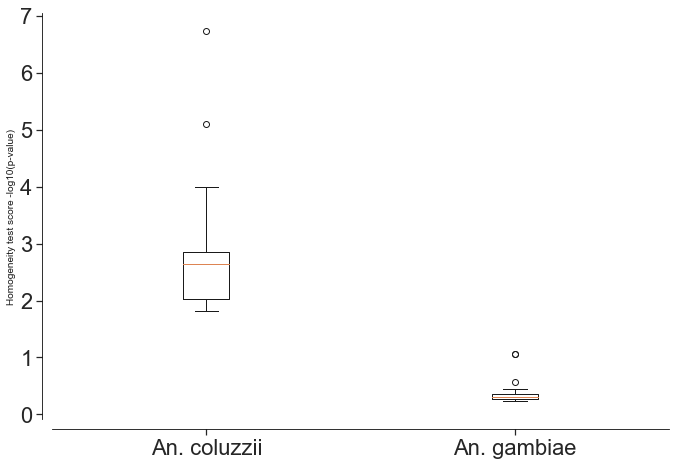

In [63]:
fig, ax = plt.subplots(figsize=(10,7))
gambiae_hom = homogen_select_gambiae['score'].list()[:20]
coluzzii_hom  = homogen_select_coluzzii['score'].list()[:20]
ax.boxplot([coluzzii_hom, gambiae_hom])
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)

fig.tight_layout()
#plt.savefig('/home/randomx/hka/homogen_test/distribution_top20_allgenes_v2.png', dpi=500)

<i>An.coluzzii</i> evolve rapidly and being under strong positive selction following the divergence from <i>An.gambiae</i>

--------------------------------------

# HKA Test

In [64]:
# calculate ABCD genome wide (in all genes with both fixed and segregating variants)
A_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_segreg')[2] for chrom in contigs])
C_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_fixed')[2] for chrom in contigs])
B_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_segreg')[2] for chrom in contigs])
D_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_fixed')[2] for chrom in contigs])

In [65]:
# calculate A/C and B/D genome wide
AC_geno_wide = A_geno_wide_coluzzii / C_geno_wide_coluzzii
print('\n', 'A genome wide: ', A_geno_wide_coluzzii, '\n', 'C genome wide: ', C_geno_wide_coluzzii, '\n', 'A/C genome wide: ', AC_geno_wide)
BD_geno_wide = B_geno_wide_gambiae / D_geno_wide_gambiae
print('\n', 'B genome wide: ', B_geno_wide_gambiae, '\n', 'D genome wide: ', D_geno_wide_gambiae, '\n', 'B/D genome wide: ', BD_geno_wide)


 A genome wide:  266013.0 
 C genome wide:  1709.0 
 A/C genome wide:  155.6541837331773

 B genome wide:  244880.0 
 D genome wide:  1100.0 
 B/D genome wide:  222.61818181818182


In [66]:
def get_conti(chrom, species, joi_seg_fix, seg_geno_wide, fixed_geno_wide):
    conti_tbl = {}
    for rec in joi_seg_fix[chrom].records():
        if species == 'coluzzii':
            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            gene = rec.genes
            conti_tbl[gene] = [[A, C], [seg_geno_wide, fixed_geno_wide]]
        if species == 'gambiae':
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[gene] = [[B, D], [seg_geno_wide, fixed_geno_wide]]
    return conti_tbl

In [67]:
def perform_pear_chi(species):
    pear_chi = {}
    conti_tbl = {}
    for chrom in contigs:
        if species == 'coluzzii':
            conti_tbl[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
        if species == 'gambiae':
            conti_tbl[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
        pear_chi[chrom] = {}
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [68]:
pear_chi_coluzzii = perform_pear_chi('coluzzii')
pear_chi_gambiae = perform_pear_chi('gambiae')

In [69]:
conti_tbl_coluzzii = {}
conti_tbl_gambiae = {}
for chrom in contigs:
    conti_tbl_gambiae[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    conti_tbl_coluzzii[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)

In [70]:
with open('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/AOcol_vs_GAgam/gambiae_hka_summary.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_g', 'pri_der_fix_g', 'score_g']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_gambiae[chrom].items():
            row = [chrom, gene, conti_tbl_gambiae[chrom][gene][0][0], conti_tbl_gambiae[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


In [71]:
with open('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/AOcol_vs_GAgam/coluzzii_hka_summary.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_c', 'pri_der_fix_c', 'score_c']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_coluzzii[chrom].items():
            row = [chrom, gene, conti_tbl_coluzzii[chrom][gene][0][0], conti_tbl_coluzzii[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


----------------------------------

In [72]:
hka_gambiae = etl.fromtsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/AOcol_vs_GAgam/gambiae_hka_summary.tab', delimiter='\t')
hka_gambiae.convert('score_g', float).select(lambda rec: rec.score_g >= 1.3).displayall()

chrom,gene,segreg_g,pri_der_fix_g,score_g
3L,AGAP011979,60,3,4.54050755879
3R,AGAP007735,17,2,5.93224848319
3R,AGAP007732,266,32,146.271040488
3R,AGAP007731,89,10,41.2863891475
3R,AGAP007759,206,4,2.08568636904
3R,AGAP007736,1072,72,177.93909465
3R,AGAP007762,45,5,18.8183505356
3R,AGAP007761,405,19,32.3548616086
3R,AGAP007737,53,2,1.94506814153
3R,AGAP007754,120,4,4.11951372618


In [73]:
hka_coluzzii = etl.fromtsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/AOcol_vs_GAgam/coluzzii_hka_summary.tab', delimiter='\t')
hka_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c
3L,AGAP011094,126,1,0.137222990581
3L,AGAP012056,254,1,0.0360787295682
3L,AGAP012275,121,1,0.124257799218
3L,AGAP012289,107,1,0.0868003519324
3L,AGAP011479,368,2,0.0325229006841
3R,AGAP007735,10,2,6.59880983049
3R,AGAP010307,65,1,0.0441304144016
3R,AGAP009933,520,2,0.188424283431
3R,AGAP009959,107,2,0.476445590004
3R,AGAP007759,83,2,0.715349732498


-----------------------

## Disruptive selection
Also called diversifying selection, describes changes in population genetics in which extreme values for a trait are favored over intermediate values. In this case, the variance of the trait increases and the population is divided into two distinct groups. In this more individuals acquire peripheral character value at both ends of the distribution curve.



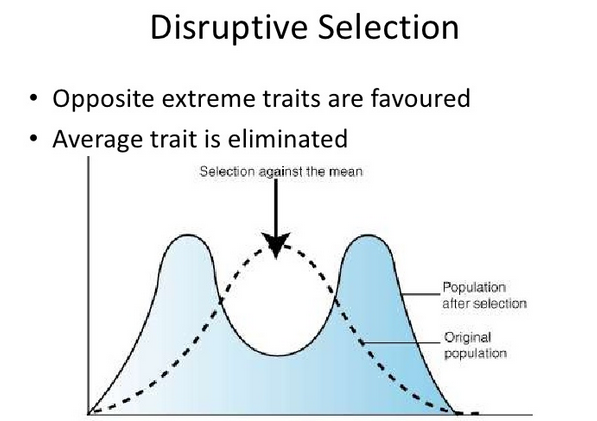

In [75]:
Image(filename='/home/randomx/Immagini/disruptive_sel.jpg')

In [93]:
disr_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    #.select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True)
    )
disr_select.tocsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/AOcol_vs_GAgam/putative_directional_selection.tab', delimiter='\t')
disr_select.display(100)

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
3R,AGAP007736,694,70,181.366668346,1072,72,177.93909465,359.305762996
3R,AGAP007732,94,23,138.13159028,266,32,146.271040488,284.402630768
X,AGAP001076,44,12,76.7447852545,25,10,122.040738982,198.7855242365
X,AGAP001035,23,14,163.002568479,28,5,29.0285218378,192.03109031679998
X,AGAP013341,9,10,159.104816487,18,4,26.6979425803,185.8027590673
X,AGAP001023,63,6,13.6445441877,100,20,145.076233044,158.7207772317
2R,AGAP013121,130,24,112.612750487,167,9,17.3940607981,130.0068112851
3R,AGAP007731,34,11,80.2241867194,89,10,41.2863891475,121.5105758669
2R,AGAP004643,18,7,56.1288519008,18,4,26.6979425803,82.8267944811
X,AGAP001041,3,1,2.537194239,1,3,76.290418468,78.827612707


In [77]:
disr_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    .select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True))
disr_select.tocsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/AOcol_vs_GAgam/putative_directional_selection.tab', delimiter='\t')
disr_select.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
3R,AGAP007736,694,70,181.366668346,1072,72,177.93909465,359.305762996
3R,AGAP007732,94,23,138.13159028,266,32,146.271040488,284.402630768
X,AGAP001076,44,12,76.7447852545,25,10,122.040738982,198.7855242365
X,AGAP001035,23,14,163.002568479,28,5,29.0285218378,192.03109031679998
X,AGAP013341,9,10,159.104816487,18,4,26.6979425803,185.8027590673
X,AGAP001023,63,6,13.6445441877,100,20,145.076233044,158.7207772317
2R,AGAP013121,130,24,112.612750487,167,9,17.3940607981,130.0068112851
3R,AGAP007731,34,11,80.2241867194,89,10,41.2863891475,121.5105758669
2R,AGAP004643,18,7,56.1288519008,18,4,26.6979425803,82.8267944811
X,AGAP001026,21,6,37.0740140902,12,4,36.9117251829,73.9857392731


## Genes which experienced private selection
Based on the hka-test score (1.3) here we indentify genes that there are only in one specimen

In [78]:
hka_gambiae_coluzzii = hka_coluzzii.outerjoin(hka_gambiae, key=['chrom', 'gene']).convert(['score_g', 'score_c'], float)

In [79]:
priv_sel_coluzzii =  (hka_gambiae_coluzzii.selectne('score_c', None).convert('score_g', {None: 0})
                     .select(lambda r: r.score_c >= 1.3 and r.score_g <= 1.3).sort('score_c', reverse=True))

priv_sel_coluzzii.tocsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/AOcol_vs_GAgam/priv_sel_coluzzii.tab', delimiter='\t')
priv_sel_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
2R,AGAP002824,718,27,22.4878156879,1425,8,0.175525770201
X,AGAP013181,15,4,21.6117440221,None,None,0
X,AGAP000988,2,2,19.6548640532,None,None,0
2R,AGAP004306,20,4,16.977244062,None,None,0
X,AGAP001025,28,4,12.5628285775,23,1,0.638458505618
2R,AGAP013294,469,16,11.7128937856,960,3,0.156138763929
2R,AGAP003479,134,8,11.3796724617,270,3,0.607707919146
2L,AGAP005169,52,5,11.1886492646,None,None,0
X,AGAP000994,17,3,10.5472260406,28,1,0.518536319805
2R,AGAP004333,118,7,9.78175796925,194,3,1.07397209836


In [80]:
priv_sel_gambiae =  (hka_gambiae_coluzzii.selectne('score_g', None).convert('score_c', {None: 0})
                     .select(lambda r: r.score_g >= 1.3 and r.score_c <= 1.3).sort('score_g', reverse=True))
priv_sel_gambiae.tocsv('/home/randomx/Dropbox/Ag1000G_carlo/notebooks/tables/hka/AOcol_vs_GAgam/priv_sel_gambiae.tab', delimiter='\t')
priv_sel_gambiae.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP000975,None,None,0,13,5,53.9806779952
X,AGAP001083,11,1,0.903123764863,7,3,30.4906091436
2L,AGAP004698,None,None,0,11,3,21.73310767
X,AGAP000010,20,1,0.500038771492,13,3,18.9906009206
3R,AGAP007762,None,None,0,45,5,18.8183505356
X,AGAP000837,109,2,0.460956171689,108,7,16.1248571114
X,AGAP001042,None,None,0,5,2,16.0269195554
X,AGAP001030,11,1,0.903123764863,16,3,15.9545353964
X,AGAP000986,35,1,0.242617747716,54,5,15.7882551395
X,AGAP001039,21,1,0.47370385054,18,3,14.4098662788
